In [106]:
import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter  # noqa: F401

from utils import EWM_ALPHA, WINDOW_SIZE, read_metrics_file, z_score

warnings.filterwarnings("ignore")

In [107]:
# data = load_data("./data/ForbushDecrease/2024-03-24/all.txt")
data = read_metrics_file(
    "Forbush Decrease",
    "2024-03-24",
    "INVK",
    WINDOW_SIZE,
    datetime_cols={"datetime": None},
    suffix=f"-ewm_alpha_{EWM_ALPHA}",
)

data.rename(columns={"value": "INVK"}, inplace=True)

data

,datetime,INVK,window_shape,entropy,sampen,permutation_entropy,shannon_entropy,spectral_entropy,app_entropy,hurst,dfa,mfhurst_b,higuchi_fd,katz_fd,petrosian_fd,lepel_ziv,corr_dim
0,2024-03-23 00:00:00,176.975000,65,4.174383,1.365241,2.463747,1.843255,0.566053,0.467798,0.748449,1.420918,0.283930,1.694791,2.586095,1.042302,12,1.120089
1,2024-03-23 00:02:00,178.004730,66,4.189651,1.452252,2.453054,1.837166,0.571650,0.494265,0.744301,1.401543,0.284971,1.698899,2.572570,1.041529,13,1.121616
2,2024-03-23 00:04:00,176.584038,67,4.204689,1.427116,2.441868,1.829673,0.581919,0.502788,0.760669,1.416485,0.283032,1.697297,2.565709,1.040782,13,1.108476
3,2024-03-23 00:06:00,176.181092,68,4.219504,1.504077,2.452257,1.823485,0.588354,0.495335,0.744301,1.421539,0.279009,1.697246,2.576480,1.041339,13,1.115023
4,2024-03-23 00:08:00,176.710643,69,4.234103,1.504077,2.457567,1.816837,0.599945,0.473677,0.744301,1.417731,0.281842,1.698730,2.562921,1.041873,13,1.134341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2024-03-26 11:50:00,172.977697,70,4.248482,0.693147,2.530396,1.893482,0.375178,0.530651,0.783887,1.002077,0.504706,1.536888,1.797146,1.048496,12,1.312582
2516,2024-03-26 11:52:00,173.096543,69,4.234093,0.664327,2.530048,1.881224,0.385447,0.517863,0.846609,1.080272,0.502588,1.541191,1.771689,1.049340,13,1.321550
2517,2024-03-26 11:54:00,173.065561,68,4.219494,0.664327,2.528026,1.865102,0.393038,0.525379,0.849434,1.220484,0.509654,1.542267,1.686143,1.050212,13,1.320716
2518,2024-03-26 11:56:00,173.743477,67,4.204679,0.669617,2.518802,1.843647,0.403990,0.528556,0.954889,1.214189,0.511551,1.545192,1.626799,1.049833,13,1.319102


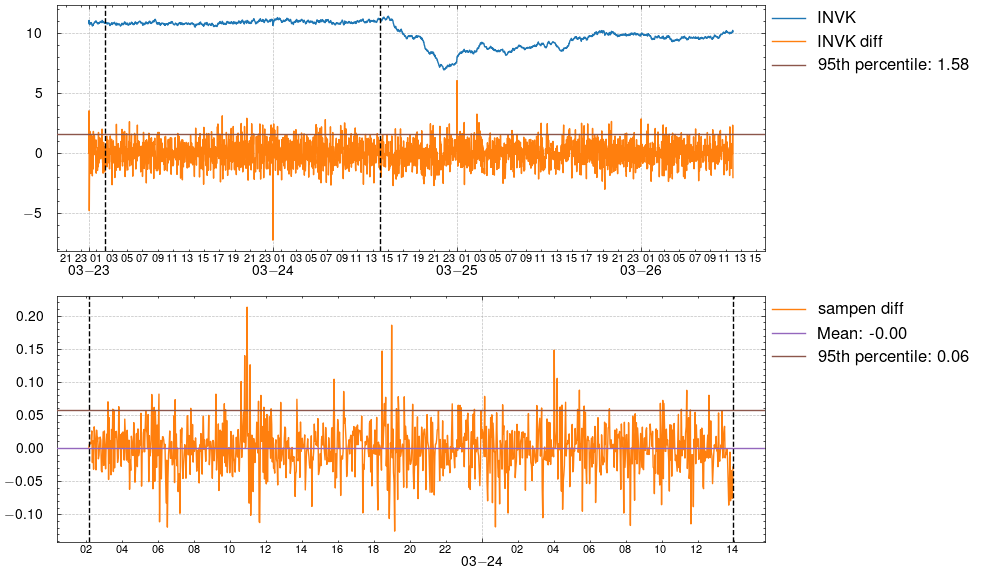

In [110]:
# Differentiating with numpy
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

ax1, ax2 = axes

# Plot original data
col = "INVK"
offset = 10
percentil = 95

x = data["datetime"]
y = data[col]
diff_np = np.diff(y, prepend=y.iloc[0])

diff_np = z_score(diff_np)
ax1.plot(x, z_score(y) + offset, label=col, color="tab:blue")

# Numpy differentiate
ax1.plot(x, diff_np, label=f"{col} diff", color="tab:orange")

# Savitzky-Golay filter
# y_smooth = savgol_filter(y, window_length=10, polyorder=3)
# dy = np.gradient(y_smooth, x.astype("int64") / 1e9)
# ax1.plot(x, z_score(dy), label="savgol_filter", color="tab:green")
# ax1.plot(x, z_score(y_smooth) + 10, label="savgol smooth", color="tab:red")

diff_percentil = np.percentile(diff_np, percentil)

ax1.axhline(
    diff_percentil,
    label=f"{percentil}th percentile: {diff_percentil:.2f}",
    color="tab:brown",
    zorder=100,
)

# Plot the second axis
interest_df = data[
    (data["window_shape"] == WINDOW_SIZE)
    & (data["datetime"] < "2024-03-24 14:00:00")
]

col = "sampen"
offset = 5

x = interest_df["datetime"]
y = interest_df[col]
diff_np = np.diff(y, prepend=y.iloc[0])

# Numpy differentiate
ax2.plot(x, diff_np, label=f"{col} diff", color="tab:orange")

# Savitzky-Golay filter
# y_smooth = savgol_filter(y, window_length=10, polyorder=3)
# dy = np.gradient(y_smooth, x.astype("int64") / 1e9)
# ax2.plot(x, z_score(dy), label="savgol_filter", color="tab:green")
# ax2.plot(x, z_score(y_smooth) + 10, label="savgol smooth", color="tab:red")

diff_percentil = np.percentile(diff_np, percentil)

ax2.axhline(
    diff_np.mean(),
    label=f"Mean: {diff_np.mean():.2f}",
    color="tab:purple",
    zorder=100,
)

ax2.axhline(
    diff_percentil,
    label=f"{percentil}th percentile: {diff_percentil:.2f}",
    color="tab:brown",
    zorder=100,
)

# Configure yticks
# ax1.set_yticklabels([])


# Configure xticks
def setup_datetime_axis(ax, hours=2):
    major_locator = mdates.DayLocator()
    minor_locator = mdates.HourLocator(interval=hours)
    major_formatter = mdates.DateFormatter("%m-%d")
    minor_formatter = mdates.DateFormatter("%H")

    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_minor_formatter(minor_formatter)

    ax.tick_params(which="major", labelsize=10, rotation=0, pad=10)
    ax.tick_params(which="minor", labelsize=8, rotation=0, pad=2)


# Apply to each subplot after plotting
setup_datetime_axis(ax1, hours=2)
setup_datetime_axis(ax2, hours=2)

min_time = interest_df["datetime"].min()
max_time = interest_df["datetime"].max()
for ax in [ax1, ax2]:
    ax.axvline(min_time, color="black", linestyle="--")
    ax.axvline(max_time, color="black", linestyle="--")

    ax.grid(True, which="major", alpha=0.8, linestyle="--")
    ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)

fig.tight_layout()

plt.savefig("img.pdf")
plt.show()

In [105]:
a = data.set_index("datetime").diff()
data_windows = data[data["window_shape"] == WINDOW_SIZE]
indexes = data_windows.index
a_index = a.iloc[indexes]
quantile_95 = a_index.quantile(0.95)

display(
    quantile_95,
    np.percentile(a_index["sampen"], 95),
    np.where(a_index["sampen"] > quantile_95["sampen"], 0, a_index["sampen"]),
    a_index[a_index["sampen"] >= quantile_95["sampen"]]["sampen"],
    tmp := a_index[a_index["sampen"] >= quantile_95["sampen"]]["sampen"],
    argmax := tmp.argmax(),
    a_index.iloc[argmax] if not tmp.empty else None,
    tmp.idxmax(),
)

INVK                   0.463222
window_shape           0.000000
entropy                0.000002
sampen                 0.045852
permutation_entropy    0.009655
shannon_entropy        0.041432
spectral_entropy       0.007922
app_entropy            0.019439
hurst                  0.049305
dfa                    0.179147
mfhurst_b              0.007396
higuchi_fd             0.008862
katz_fd                0.268220
petrosian_fd           0.000571
lepel_ziv              1.000000
corr_dim               0.015802
Name: 0.95, dtype: float64

np.float64(0.045851588149390166)

array([ 0.0106384 ,  0.00527706,  0.00827591, ..., -0.00457893,
       -0.00439735,  0.00190138], shape=(2391,))

datetime
2024-03-23 03:14:00    0.069917
2024-03-23 03:18:00    0.045889
2024-03-23 03:30:00    0.058841
2024-03-23 03:34:00    0.057403
2024-03-23 03:50:00    0.062520
                         ...   
2024-03-26 04:26:00    0.065505
2024-03-26 04:28:00    0.061398
2024-03-26 04:58:00    0.055350
2024-03-26 07:12:00    0.072337
2024-03-26 07:58:00    0.052917
Name: sampen, Length: 120, dtype: float64

datetime
2024-03-23 03:14:00    0.069917
2024-03-23 03:18:00    0.045889
2024-03-23 03:30:00    0.058841
2024-03-23 03:34:00    0.057403
2024-03-23 03:50:00    0.062520
                         ...   
2024-03-26 04:26:00    0.065505
2024-03-26 04:28:00    0.061398
2024-03-26 04:58:00    0.055350
2024-03-26 07:12:00    0.072337
2024-03-26 07:58:00    0.052917
Name: sampen, Length: 120, dtype: float64

np.int64(26)

INVK                  -7.829548e-01
window_shape           0.000000e+00
entropy               -2.125606e-08
sampen                 2.597549e-02
permutation_entropy    7.319914e-03
shannon_entropy        2.327253e-03
spectral_entropy       4.610394e-04
app_entropy            1.029560e-02
hurst                 -1.773395e-02
dfa                   -2.357788e-01
mfhurst_b              2.630197e-03
higuchi_fd             2.984195e-03
katz_fd               -6.725609e-02
petrosian_fd           5.689908e-04
lepel_ziv              1.000000e+00
corr_dim              -5.254859e-03
Name: 2024-03-23 03:02:00, dtype: float64

Timestamp('2024-03-23 10:58:00')

In [ ]:
a = data.set_index("datetime").diff()
data_windows = data[data["window_shape"] == WINDOW_SIZE]
indexes = data_windows.index